In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import re
from numpy.linalg import norm
from collections import Counter, defaultdict
from scipy.sparse import csr_matrix
from pyparsing import anyOpenTag, anyCloseTag
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


In [2]:
# read in the dataset
#with open("data/train.dat", "r") as tr:
#    docs2 = tr.readlines()
#print len(docs2)

def csr_read(fname, ftype="csr", nidx=1):
    r""" 
        Read CSR matrix from a text file. 
        
        \param fname File name for CSR/CLU matrix
        \param ftype Input format. Acceptable formats are:
            - csr - Compressed sparse row
            - clu - Cluto format, i.e., CSR + header row with "nrows ncols nnz"
        \param nidx Indexing type in CSR file. What does numbering of feature IDs start with?
    """
    
    with open(fname) as f:
        lines = f.readlines()
    
    if ftype == "clu":
        p = lines[0].split()
        nrows = int(p[0])
        ncols = int(p[1])
        nnz = long(p[2])
        lines = lines[1:]
        assert(len(lines) == nrows)
    elif ftype == "csr":
        nrows = len(lines)
        ncols = 0 
        nnz = 0 
        for i in xrange(nrows):
            p = lines[i].split()
            if len(p) % 2 != 0:
                raise ValueError("Invalid CSR matrix. Row %d contains %d numbers." % (i, len(p)))
            nnz += len(p)/2
            for j in xrange(0, len(p), 2): 
                cid = int(p[j]) - nidx
                if cid+1 > ncols:
                    ncols = cid+1
    else:
        raise ValueError("Invalid sparse matrix ftype '%s'." % ftype)
    val = np.zeros(nnz, dtype=np.float)
    ind = np.zeros(nnz, dtype=np.int)
    ptr = np.zeros(nrows+1, dtype=np.long)
    n = 0 
    for i in xrange(nrows):
        p = lines[i].split()
        for j in xrange(0, len(p), 2): 
            ind[n] = int(p[j]) - nidx
            val[n] = float(p[j+1])
            n += 1
        ptr[i+1] = n 
    
    assert(n == nnz)
    
    return csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.float)

In [3]:
csr_mat = csr_read("train.dat", ftype="csr", nidx=1)

In [4]:
def build_matrix(docs):
    r""" Build sparse matrix from a list of documents, 
    each of which is a list of word/terms in the document.  
    """
    nrows = len(docs)
    idx = {}
    tid = 0
    nnz = 0
    for d in docs:
        nnz += len(set(d))
        for w in d:
            if w not in idx:
                idx[w] = tid
                tid += 1
    ncols = len(idx)
        
    # set up memory
    ind = np.zeros(nnz, dtype=np.int)
    val = np.zeros(nnz, dtype=np.double)
    ptr = np.zeros(nrows+1, dtype=np.int)
    i = 0  # document ID / row counter
    n = 0  # non-zero counter
    # transfer values
    for d in docs:
        cnt = Counter(d)
        keys = list(k for k,_ in cnt.most_common())
        l = len(keys)
        for j,k in enumerate(keys):
            ind[j+n] = idx[k]
            val[j+n] = cnt[k]
        ptr[i+1] = ptr[i] + l
        n += l
        i += 1
            
    mat = csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.double)
    mat.sort_indices()
    
    return mat

def csr_idf(mat, copy=False, **kargs):
    r""" Scale a CSR matrix by idf. 
    Returns scaling factors as dict. If copy is True, 
    returns scaled matrix and scaling factors.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # document frequency
    df = defaultdict(int)
    for i in ind:
        df[i] += 1
    # inverse document frequency
    for k,v in df.items():
        df[k] = np.log(nrows / float(v))  ## df turns to idf - reusing memory
    # scale by idf
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return df if copy is False else mat

def csr_info(mat, name="", non_empy=False):
    r""" Print out info about this CSR matrix. If non_empy, 
    report number of non-empty rows and cols as well
    """
    if non_empy:
        print("%s [nrows %d (%d non-empty), ncols %d (%d non-empty), nnz %d]" % (
                name, mat.shape[0], 
                sum(1 if mat.indptr[i+1] > mat.indptr[i] else 0 
                for i in range(mat.shape[0])), 
                mat.shape[1], len(np.unique(mat.indices)), 
                len(mat.data)))
    else:
        print( "%s [nrows %d, ncols %d, nnz %d]" % (name, 
                mat.shape[0], mat.shape[1], len(mat.data)) )
        
def csr_l2normalize(mat, copy=False, **kargs):
    r""" Normalize the rows of a CSR matrix by their L-2 norm. 
    If copy is True, returns a copy of the normalized matrix.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = 1.0/np.sqrt(rsum)
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    if copy is True:
        return mat


In [5]:
csr_info(csr_mat)

 [nrows 8580, ncols 126355, nnz 1107980]


In [6]:
csr_mat_idf = csr_idf(csr_mat, copy=True)
csr_final = csr_l2normalize(csr_mat_idf, copy=True)
csr_info(csr_final)

 [nrows 8580, ncols 126355, nnz 1107980]


In [8]:
from sklearn.decomposition import TruncatedSVD
svd2 = TruncatedSVD(n_components=800, n_iter=7, random_state=35)
svdfit2 = svd2.fit(csr_final)
train_reduced = svdfit2.transform(csr_final)
print train_reduced.shape


(8580, 800)


In [9]:
from sklearn.utils import shuffle
from scipy.sparse import csr_matrix
import random
#suffling the records to pick random centroids/points
def pickCentroids(mat, k):
    shuffle_mat = shuffle(mat, random_state=0)
    #print("in pick centroids")
    return shuffle_mat[:k,:]

#cosine similarity is calculated with centroids and the points are assigned to a cluster
def assignPointsToClusters(mat, centroids):
    #compute cosine similarity
    cluster_numberslist = list()
    cossim_mat = mat.dot(centroids.T)
    #print cossim_mat.shape
    for i in range(0, cossim_mat.shape[0]):
        #eachrow = cossim_mat.getrow(i).toarray()
        eachrow = cossim_mat.getrow(i).toarray()[0]
        #sort the row of similraities with centroids
        most_similar_index = eachrow.argsort()[-1]
        cluster_number = most_similar_index+1
        cluster_numberslist.append(cluster_number)
    #print("in assignpointtocluster")
    return cluster_numberslist

#recomputing centroids
def computeCentroids(mat, clusterlist, k):
    computed_centroids = list()
    for i in range(1, k+1):
        #cluster_points = list()
        #for j in range(0, len(clusterlist)):
        #    if(clusterlist[j] == i):
        #        cluster_points.append(mat[j,:])
        
        indexes = [j for j, c in enumerate(clusterlist) if c == i]
        cluster_points = mat[indexes,:]
        if(cluster_points.shape[0] > 1):
            
            computed_centroids.append(np.mean(cluster_points.toarray(), axis=0))
        #print ("this is printing")
        #print computed_centroids
    computed_centroids_csrmat = csr_matrix(computed_centroids)
    #print("in compute centroids")
    return computed_centroids_csrmat       

In [10]:
def kmeans(mat, kclusters):
    #first step of kmeans to pick k centroids for k clusters randomly
    intial_centroids = pickCentroids(mat, kclusters)
    for i in range(0, 25):
        #print("in loop "+ i)
        #should assign remaining points to clusters based on similarity with randomly chosen centroids
        clusternumberlist = assignPointsToClusters(mat, intial_centroids)
        #should recompute centroids
        intial_centroids = computeCentroids(mat, clusternumberlist, kclusters)
    print ("done with kmeans")
    return clusternumberlist

In [14]:
from sklearn.metrics import silhouette_score
from scipy.sparse import csr_matrix
def biseckingKmeans(mat, kclusters):
    print(" bisecking k means called wiht --> "+str(kclusters))
    #should consider all the points in one cluster. it is already a matrix
    initial_cluster = list()
    initial_cluster.append(mat)
    noof_clusters = 1
    clusterindex = list()
    for i in range(0, mat.shape[0]):
        #print("in loop "+ str(i))
        clusterindex.append(1)
    cid = 1
    for i in range(1, kclusters):
        #print("in cluster loop "+ str(i))
        #print("selected cid " + str(cid))
        index_track = list()
        target_list = list()

        for j in range(0, len(clusterindex)):
            #print("in matrix process loop "+ str(j))
            #prepare target matrix
            #also backtrack array
            if(clusterindex[j] == cid):
                #print("in if loop")
                target_list.append(mat[j,:])
                index_track.append(j)
            elif(clusterindex[j] > cid):
                #print("in else loop")
                #If cluser id is > cid then shift it to new cluster id
                clusterindex[j] = clusterindex[j]+1
        #print("this is target list")
        #print(target_list)
        target_mat = csr_matrix(target_list)
        #print("before calling kmeans")
        processed_index = kmeans(target_mat, 2)
        #print("kmeans done for " + str(cid))
        #update processed cluster ids
        for z in range(0, len(processed_index)):
            #print(" in loop to increment the result of k means 2nd cluster")
            if(processed_index[z] == 2):
                #print("in if loop of incrementing")
                clusterindex[index_track[z]] = cid + 1
        #print("these are clusterindex")
        #print(clusterindex)
        #array of size == i
        #initilize each index with 0
        temp = list()
        for k in range(0, i+1):
            #print("in loop to keep track of cluster : index "+str(k))
            temp.append(0)
        #print("length of temp " + str(len(temp)))
        for j in range(0, len(clusterindex)):
            
            clusterIndex = clusterindex[j] - 1;
            #print("in loop to count no.of instances in each cluster " + str(clusterIndex))
            temp[clusterIndex] = temp[clusterIndex] + 1
        
        max = temp[0]
        cid = 1
        #print("to begin with max element is  "+str(max))
        for k in range(1, i+1):
            #print("in sorting and taking the cluster : index "+str(k))
            if (temp[k] > max):
                #print("new max "+str(temp[k])+" new cid "+str(k+1))
                cid = k + 1
        
    return clusterindex   

In [20]:
print_cluster = biseckingKmeans(train_reduced, 7)
print_cluster = kmeans(csr_final, 7)
print("####################################################")
test = open("results.txt", "w")
print("Done bisecking kmeans")
for i in range(0, len(print_cluster)):
    test.write(str(print_cluster[i]))
    test.write('\n')
test.close()
X = list()
Y = list()
for k in range(3, 22, 2):
    clusterid = biseckingKmeans(train_reduced, k)
    print("Done bisecking Kmeans for cluter size "+str(k)) 
    s_score =silhouette_score(train_reduced, clusterid, metric='cosine')
    X.append(k)
    Y.append(s_score)
    
print "Final Score: "
print(silhouette_score(csr_final.toarray(), print_cluster, metric='cosine'))


 bisecking k means called wiht --> 3
done with kmeans
done with kmeans
Done bisecking Kmeans for cluter size 3
 bisecking k means called wiht --> 5
done with kmeans
done with kmeans
done with kmeans
done with kmeans
Done bisecking Kmeans for cluter size 5
 bisecking k means called wiht --> 7
done with kmeans
done with kmeans
done with kmeans
done with kmeans
done with kmeans
done with kmeans
Done bisecking Kmeans for cluter size 7
 bisecking k means called wiht --> 9
done with kmeans
done with kmeans
done with kmeans
done with kmeans
done with kmeans
done with kmeans
done with kmeans
done with kmeans
Done bisecking Kmeans for cluter size 9
 bisecking k means called wiht --> 11
done with kmeans
done with kmeans
done with kmeans
done with kmeans
done with kmeans
done with kmeans
done with kmeans
done with kmeans
done with kmeans
done with kmeans
Done bisecking Kmeans for cluter size 11
 bisecking k means called wiht --> 13
done with kmeans
done with kmeans
done with kmeans
done with kmea

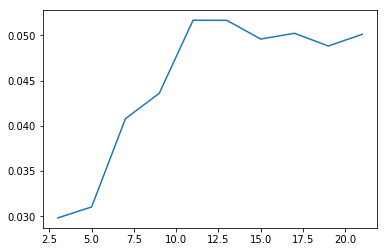

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(X, Y)